# What impacts the US Home Price
<b>Written by Xiaodan Lou
NYU Stern School of Business | May 2017</b>

### 1. Project Summary: 

US housing market has recovered significantly since last financial ciris given historically low mortgage rate and sustained strength in economy and labor market. We are interested in the understanding the driving factors of US housing market. 

### 2. Factors driving US housing market

#### Initial hypothesis:
    Strong economy, low housing supply and low mortgage rate are accomodative for home price appreciation. 

#### Factors 
* Macro economic condition:
       GDP
       Inflation (CPI)
       Labor Market (Nonfarm payrolls)
* Housing Market Supply and Demand:
       Housing Supply (New Home Sale)
* Financing Cost
        Mortgage Rate
  



### 3. Data Source

All of data used in this project is from St. Louis Fed. I used Python Fred API to directly pull data.

https://fred.stlouisfed.org/

##### Data  used are the following:

Home Price Appreciation is monitored by S&P/Case-Shiller U.S. National Home Price Index which represent the home price level of the major US 20 cities. Source URLs are listed below. 
https://fred.stlouisfed.org/series/CSUSHPINSA


2. **MtgRate: **30 Year Conventional Mortgage Rate
https://fred.stlouisfed.org/series/MORTGAGE30US

3. **CPI: **Consumer Price Index for All Urban Consumers:
https://fred.stlouisfed.org/series/CPIAUCSL

4. **GDP: **GDP (Seasonally Adjusted Annual Rate)
https://fred.stlouisfed.org/series/GDP

5. **NFP: **Nonfarm payrolls(All Employees: Total Nonfarm Payrolls)
https://fred.stlouisfed.org/series/PAYEMS

6. **HouseSupply: ** Monthly Supply of Houses in the United States
https://fred.stlouisfed.org/series/MSACSR

7. **RentalVacancy: **Rental Vacancy Rate for the United States 
https://fred.stlouisfed.org/search?st=rent

8. ** MedianSalePrice: **Median Sales Price for New Houses Sold in the United States
https://fred.stlouisfed.org/series/MSPNHSUS

9. **HouseSold: **New One Family Houses Sold: United States (HSN1F)
https://fred.stlouisfed.org/series/HSN1F

### 4. Regression Analysis

To understand the impact of factors on house price appreciation, we ran regression and performed out of sample forecasting with model trained.

**Regression Model**

$$HomePrice = \beta_0*HouseSold+\beta_1*MedianSalePrice+\beta_2*RentalVacancy+\beta_3*HouseSupply+\beta_4*NFP+\beta_5*CPI+\beta_6*GDP+\beta_7*MtgRate$$

For the modeling part, we did both OLS and Elastic Net. (Elastic Net to be illustrated later)

we can do OLS (Ordinary Least Square Regression) to model variables impact on House Price Appreciation (Percentage change of House Price Index). To account for overfitting issue which typically seen in OLS, we can use regression with regularization such as ridge/lasso regression or the combination called Elastic Net. 



In [2]:
import pandas as pd
import numpy as np
import os
%matplotlib inline 
import matplotlib.pyplot as plt       
import seaborn as sb
from fredapi import Fred
fred = Fred(api_key='b28811a83a7353bb174b68c3c2214f82')
[start_date,end_date] = ['1990-01-01','2017-02-01']

## US Home Price by Region

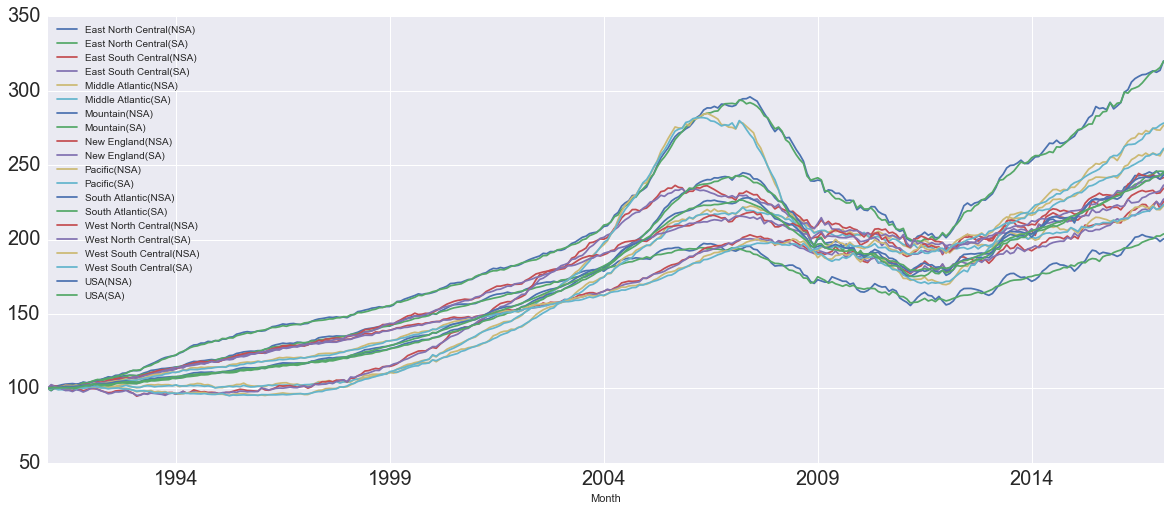

In [269]:
HPI = pd.read_excel('data/HPI_PO_monthly_hist.xls',header=3,index_col=0).dropna()
HPI.columns = [i.replace('\n','') for i in HPI.columns]
HPI.plot(figsize=(20,8),fontsize=20)

## S&P/Case-Shiller U.S. National Home Price Index

Home price is reaching historical high again.

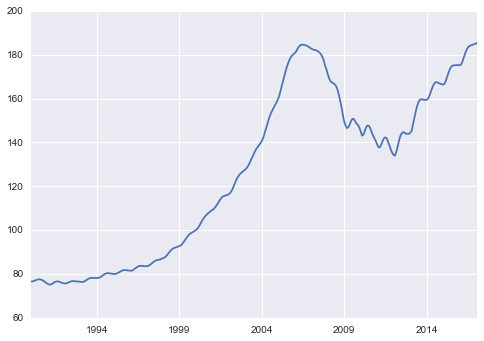

In [47]:
HPI_20city = fred.get_series('CSUSHPINSA',observation_start=start_date, observation_end=end_date)
HPI_20city.plot()

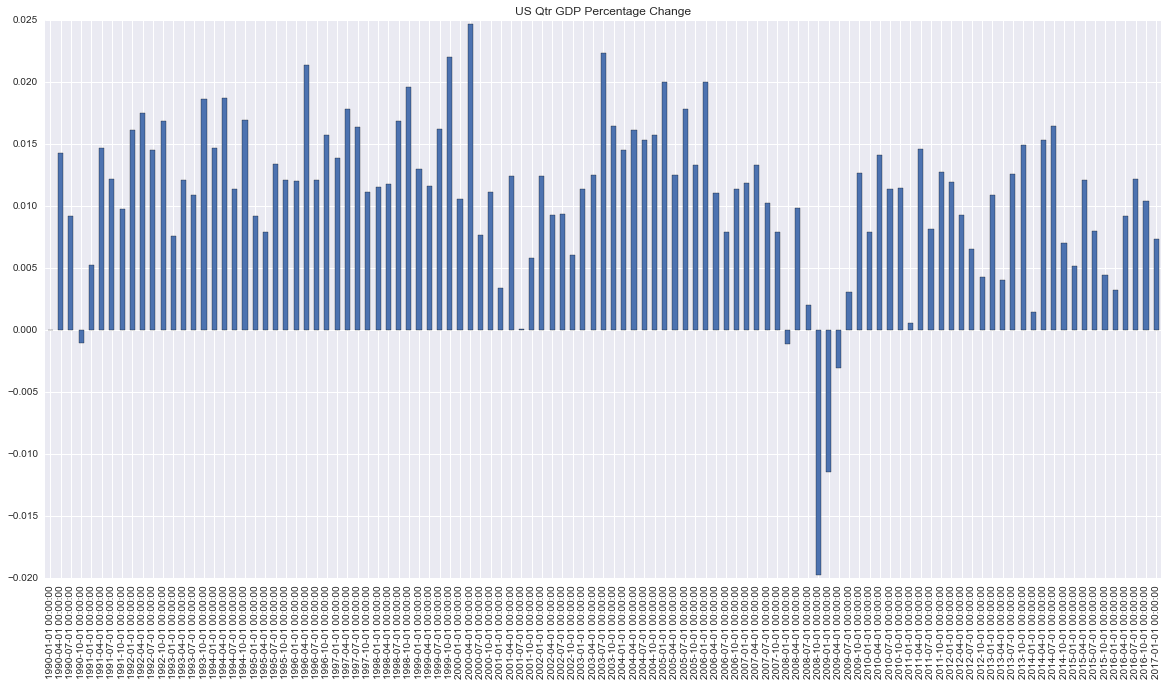

In [282]:
GDP = fred.get_series('GDP',observation_start=start_date, observation_end=end_date)
GDP.pct_change().plot(kind = 'bar',x=None,figsize = (20,10))
plt.title('US Qtr GDP Percentage Change')

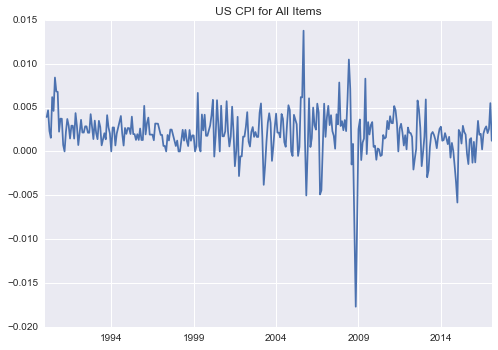

In [288]:
CPI = fred.get_series('CPIAUCSL',observation_start=start_date, observation_end=end_date)
CPI.pct_change().plot()
plt.title('US CPI for All Items')

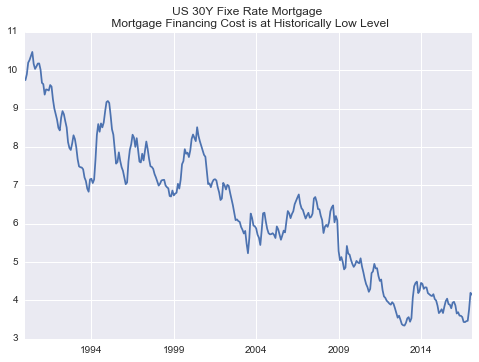

In [301]:
MtgRate_Weekly = fred.get_series('MORTGAGE30US',observation_start='1989-12-01', observation_end=end_date)
MtgRate1 = MtgRate_Weekly.resample('M').mean()# reduce to weekly to monthly by taking average
#replace month end to month start
MtgRate = pd.Series(data=MtgRate1.values,index=CPI.index)
MtgRate.plot()
plt.title('US 30Y Fixe Rate Mortgage \n Mortgage Financing Cost is at Historically Low Level')

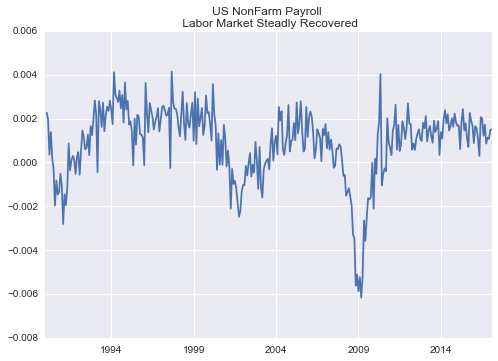

In [300]:
NFP = fred.get_series('PAYEMS',observation_start=start_date, observation_end=end_date)
NFP.pct_change().plot()
plt.title('US NonFarm Payroll \n Labor Market Steadly Recovered')

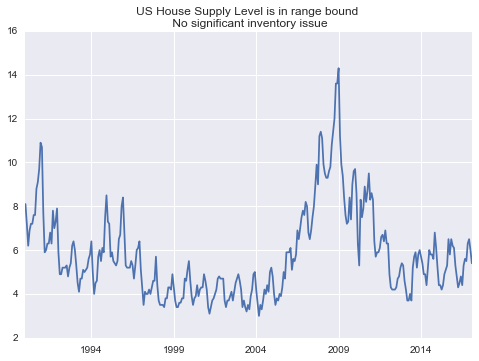

In [299]:
HouseSupply = fred.get_series('MSACSRNSA',observation_start=start_date, observation_end=end_date)
HouseSupply.plot()
plt.title('US House Supply Level is in range bound \n No significant inventory issue')

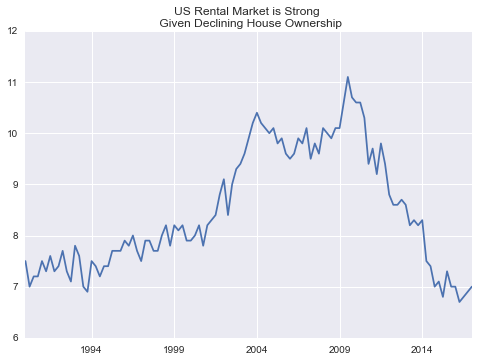

In [298]:
RentalVacancy = fred.get_series('RRVRUSQ156N',observation_start=start_date, observation_end=end_date)
RentalVacancy.plot()
plt.title('US Rental Market is Strong \n Given Declining House Ownership')

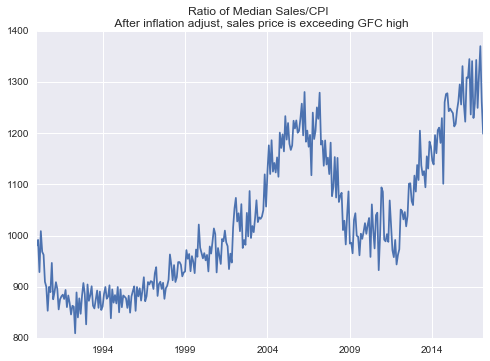

In [297]:
MedianSalePrice = fred.get_series('MSPNHSUS',observation_start=start_date, observation_end=end_date)
(MedianSalePrice/CPI).plot()
plt.title('Ratio of Median Sales/CPI \n After inflation adjust, sales price is exceeding GFC high')

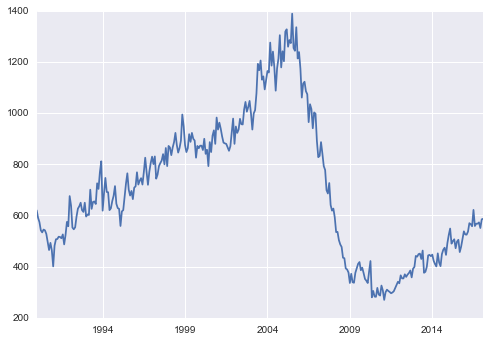

In [57]:
HouseSold = fred.get_series('HSN1F',observation_start=start_date, observation_end=end_date)
HouseSold.plot()

** After visualization of factors, we do data tranformation for the modeling part. **

## Preping Data for regression

### 1. Align data frequency  (Change Quarterly to Monthly)
Cubic interpolation is common in economics to deal with data with different frequency but induce serial correlation in data.
RentalVacancy and GDP are quarterly data. 

### 2. Change level to percentage change
This is a standardized to way to model impact of variable change to house price change.
In here, we will use percentage change of HouseSold,MedianSalePrice,RentalVacancy,HouseSupply,NFP,CPI,GDP.
Mortgage rate level will matter as its level is crucial for finance a house. Mortgage rate change will drive refinance and MBS prepayment speed which is not our focus in this project. 


In [162]:
data_raw = [HPI_20city,HouseSold,MedianSalePrice,RentalVacancy,HouseSupply,NFP,CPI,GDP,MtgRate]
data0 = pd.concat(data_raw,axis=1,keys=['HPI','HouseSold','MedianSalePrice','RentalVacancy','HouseSupply','NFP','CPI','GDP','MtgRate'])
data0.head(20)

,HPI,HouseSold,MedianSalePrice,RentalVacancy,HouseSupply,NFP,CPI,GDP,MtgRate
1990-01-01,76.53,620.0,125000.0,7.5,8.1,109185.0,127.5,5890.8,9.7440
1990-02-01,76.59,591.0,126900.0,NaN,7.2,109433.0,128.0,NaN,9.8950
1990-03-01,76.79,574.0,119400.0,NaN,6.2,109648.0,128.6,NaN,10.1975
1990-04-01,77.04,542.0,130000.0,7.0,6.9,109687.0,128.9,5974.7,10.2680
1990-05-01,77.30,534.0,125000.0,NaN,7.2,109839.0,129.1,NaN,10.3700
1990-06-01,77.50,545.0,125000.0,NaN,7.2,109861.0,129.9,NaN,10.4775
1990-07-01,77.56,542.0,118700.0,7.2,7.6,109830.0,130.5,6029.5,10.1640
1990-08-01,77.47,528.0,118400.0,NaN,7.6,109614.0,131.6,NaN,10.0350
1990-09-01,77.22,496.0,113000.0,NaN,8.8,109524.0,132.5,NaN,10.1000
1990-10-01,76.91,465.0,120000.0,7.2,9.1,109364.0,133.4,6023.3,10.1750


## Transformed Data

In [171]:
data1 = data0.interpolate(method='linear').pct_change()
data1['MtgRate'] = MtgRate.values/100
data=data1.dropna()
data.head(12)

,HPI,HouseSold,MedianSalePrice,RentalVacancy,HouseSupply,NFP,CPI,GDP,MtgRate
1990-02-01,0.000784,-0.046774,0.015200,-0.022222,-0.111111,0.002271,0.003922,0.004748,0.098950
1990-03-01,0.002611,-0.028765,-0.059102,-0.022727,-0.138889,0.001965,0.004687,0.004725,0.101975
1990-04-01,0.003256,-0.055749,0.088777,-0.023256,0.112903,0.000356,0.002333,0.004703,0.102680
1990-05-01,0.003375,-0.014760,-0.038462,0.009524,0.043478,0.001386,0.001552,0.003057,0.103700
1990-06-01,0.002587,0.020599,0.000000,0.009434,0.000000,0.000200,0.006197,0.003048,0.104775
1990-07-01,0.000774,-0.005505,-0.050400,0.009346,0.055556,-0.000282,0.004619,0.003039,0.101640
1990-08-01,-0.001160,-0.025830,-0.002527,0.000000,0.000000,-0.001967,0.008429,-0.000343,0.100350
1990-09-01,-0.003227,-0.060606,-0.045608,0.000000,0.157895,-0.000821,0.006839,-0.000343,0.101000
1990-10-01,-0.004015,-0.062500,0.061947,0.000000,0.034091,-0.001461,0.006792,-0.000343,0.101750
1990-11-01,-0.006891,0.060215,-0.009167,0.013889,0.065934,-0.001362,0.002249,0.001749,0.101775


In [172]:
data.describe()

,HPI,HouseSold,MedianSalePrice,RentalVacancy,HouseSupply,NFP,CPI,GDP,MtgRate
count,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,0.002753,0.002112,0.003525,-0.000133,0.005173,0.000891,0.002008,0.003613,0.063842
std,0.006882,0.066795,0.042550,0.012567,0.113985,0.001639,0.002613,0.002144,0.017873
min,-0.022615,-0.336493,-0.104386,-0.034335,-0.280374,-0.006172,-0.017705,-0.006670,0.033450
25%,-0.000837,-0.038394,-0.026421,-0.008811,-0.076923,0.000123,0.000969,0.002631,0.048750
50%,0.003122,0.003063,0.006178,0.000000,0.000000,0.001228,0.002038,0.003922,0.063825
75%,0.007199,0.045213,0.029447,0.008658,0.076923,0.001923,0.003171,0.004867,0.076750
max,0.020407,0.211470,0.144933,0.032864,0.566038,0.004151,0.013768,0.008218,0.104775


### Variable Correlation

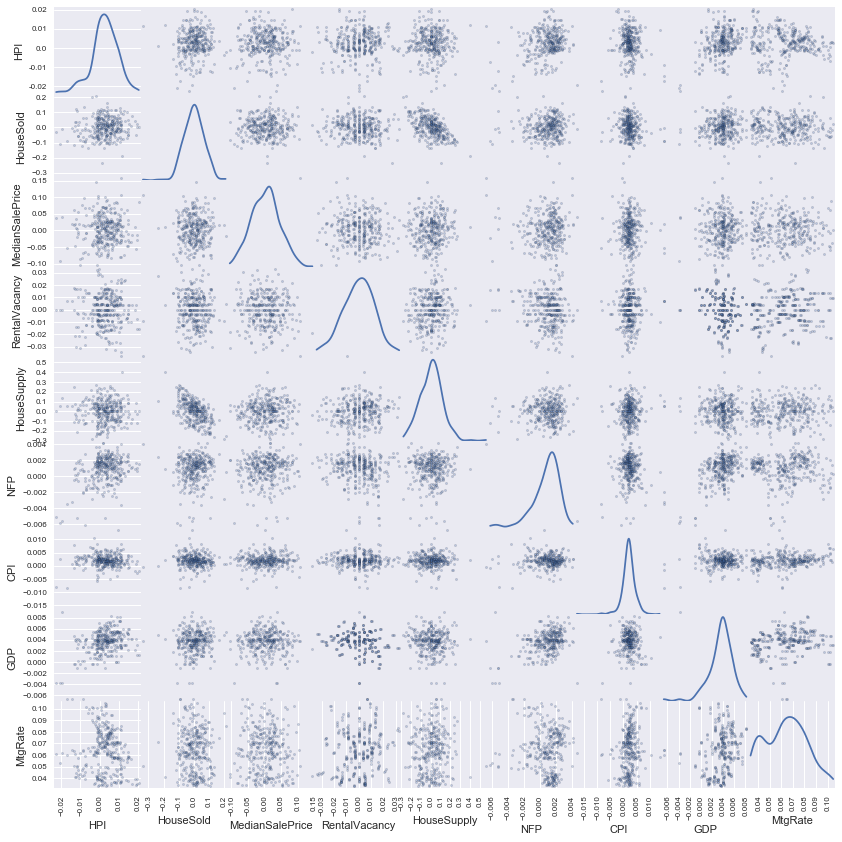

In [165]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

# Model Selection 

Typically, we can do OLS (Ordinary Least Square Regression) to model variables impact on House Price Appreciation (Percentage change of House Price Index). To account for overfitting issue which typically seen in OLS, we can use regression with regularization such as ridge ro lasso regression. However we use elastic net regression here. As for Lasso vs ElasticNet, ElasticNet will tend to select more variables hence lead to larger models but also be more accurate in general. In particular Lasso is very sensitive to correlation between features and might select randomly one out of 2 very correlated informative features while ElasticNet will be more likely to select both which should lead to a more stable model (in terms of generalization ability so new samples).

Quoted from SKlearn website--

* ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter. Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

In [224]:
# Split data in train set and test set
data_mat = np.matrix(data)
X = data.iloc[:,1:]
y = data.iloc[:,0]
n_samples = X.shape[0]
pct_train = 0.6
train_size = int(n_samples*pct_train)
test_size = n_samples-train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[test_size:], y[test_size:]

In [226]:
import statsmodels.api as sm
from IPython.display import HTML, display

#Fitting by Ordinary Least Square
model = sm.OLS(y_train,X_train)
ols_model = model.fit()
Housing_OLS = ols_model.summary()
HTML(
Housing_OLS\
.as_html()\
.replace(' Adj. R-squared: ', ' Adj. R-squared: ')\
.replace('coef', 'coef')\
.replace('std err', 'std err')\
.replace('P>|t|', 'P>|t|')\
.replace('[95.0% Conf. Int.]', '[95.0% Conf. Int.]')
)

## OLS Model result

** R^2 for OLS is  0.519. Significant Factors for HPI are CPI,GDP and Mortgage Rate with T-stats of 1.785, 6.422 and -1.766. **


# Out of Sample Forecasting

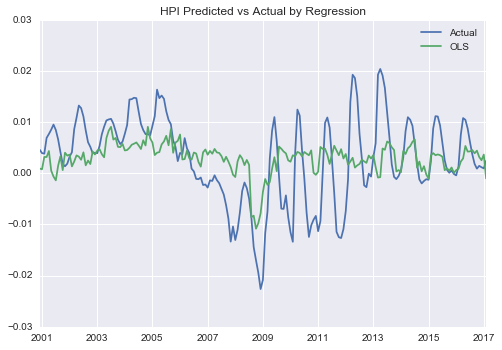

In [267]:

from sklearn.linear_model import ElasticNetCV

yp_ols = ols_model.predict(X_test)
ElasticNetModel = ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, cv=None, copy_X=True, verbose=0, n_jobs=1, positive=False, random_state=None, selection='cyclic')

YD_actual = pd.Series(y_test)
YD_OLS = pd.Series(yp_ols)
YD_OLS.index = YD_actual.index
y_pred_ENCV = ElasticNetModel.fit(X_train, y_train).predict(X_test)
YD_ElasticNet = pd.Series(y_pred_ENCV)
YD_ElasticNet.index = YD_actual.index
pd.concat([YD_actual,YD_OLS], keys=['Actual','OLS'],axis=1).plot(legend=True)
plt.title('HPI Predicted vs Actual by Regression')

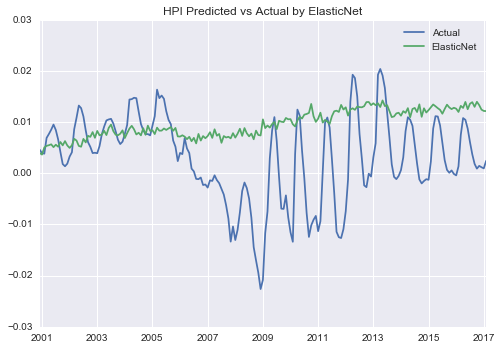

In [268]:
pd.concat([YD_actual,YD_ElasticNet], keys=['Actual','ElasticNet'],axis=1).plot(legend=True)
plt.title('HPI Predicted vs Actual by ElasticNet')

## Conclusion

This data analysis explores the reasons and main drivers for US housing market. We try to find th relationship bewteen the the price of the housing appreciation and several factors such as general market conditions, mortgage rate and housing supply and demand.  The continuation in growth has been fostered by several supporting factors: net demand running above the norm, a relentless decline in the market share of distressed home sales (now probing record lows), and easing bank lending standards.We note that the general economy condition is still the key drivers for the housing market, following by the vacancy rate ofthe exisiting home, in US based on the past 27 years of data. Higher mortgage rate can affect the demand but not excessively. 


# Appendix

### New Home Sales Vs Existing Home Sales
The Census Bureau collects new home sales based upon the following definition: 
    "A sale of the new house occurs with the signing of a sales contract or the acceptance of a deposit." 
    The house can be in any stage of construction: not yet started, under construction, or already completed. 
        Typically about 25% of the houses are sold at the time of completion. 
        The remaining 75% are evenly split between those not yet started and those under construction.

Existing home sales data are provided by the National Association of Realtors®. 
According to them, "the majority of transactions are reported when the sales contract is closed." 
Most transactions usually involve a mortgage which takes 30-60 days to close. 
Therefore an existing home sale (closing) most likely involves a sales contract that was signed a month or two prior.

Given the difference in definition, new home sales usually lead existing home sales 
regarding changes in the residential sales market by a month or two. 
For example, an existing home sale in January, was probably signed 30 to 45 days earlier 
which would have been in November or December. This is based on the usual time it takes to obtain and close a mortgage.

https://www.census.gov/construction/nrs/new_vs_existing.html
